### Walk through the baseline model for the [Ariel ML challenge 2021](https://www.ariel-datachallenge.space/).

What this notebooks does: 
- access the data using an ArielMLDataset utility class
- plot a random input light curve
- use some simple preprocessing steps for the input light curves
- train the baseline model for a subset of the data (by default)
- produce an evaluation file for the baseline model

What this notebooks does *not*:
- train on the full dataset
- explore alternative training losses
- optimise of the current model architecture
- discuss other models or architectures
- include additional parameters (only the light curves are used) 

In [1]:
# General imports
import numpy as np
import matplotlib.pylab as plt
import torch
    
from pathlib import Path

In [2]:
# Device agnostic 
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [2]:
data_dir = "/data-nbd/ml_dataset/timeseries/pkdd_ml_data_challenge2"

## Data access

In [30]:
# paths to data dirs
lc_train_path = data_dir+ "/data/noisy_train/home/ucapats/Scratch/ml_data_challenge/training_set/noisy_train"
params_train_path = data_dir+"/data/params_train/home/ucapats/Scratch/ml_data_challenge/training_set/params_train"
lc_test_path = data_dir+"/data/noisy_test/home/ucapats/Scratch/ml_data_challenge/test_set/noisy_test"

# Import Dataset class 
from utils import ArielMLDataset

In [31]:
from tqdm import tqdm
files = sorted([p for p in os.listdir(lc_train_path) if p.endswith('txt')])

dataset = ArielMLDataset(lc_train_path, params_train_path, shuffle=False)


In [19]:
%%time
full_train_signal = np.load('data/full_train_signal.npy')
# full_test_signal = np.load('data/full_test_signal.npy')
print(full_train_signal.shape)
# torch.save(torch.tensor(full_train_signal), 'data/full_train_signal.pt')

CPU times: user 60 ms, sys: 7.91 s, total: 7.97 s
Wall time: 3min


In [22]:
%%time
full_train_signal_pt = torch.load('data/full_train_signal.pt')

CPU times: user 0 ns, sys: 5.16 s, total: 5.16 s
Wall time: 5.17 s


In [34]:
full_train_signal_pt[:,:-1].shape

torch.Size([6908000, 300])

In [32]:
item = dataset[10]
item['lc'].shape

torch.Size([55, 300])

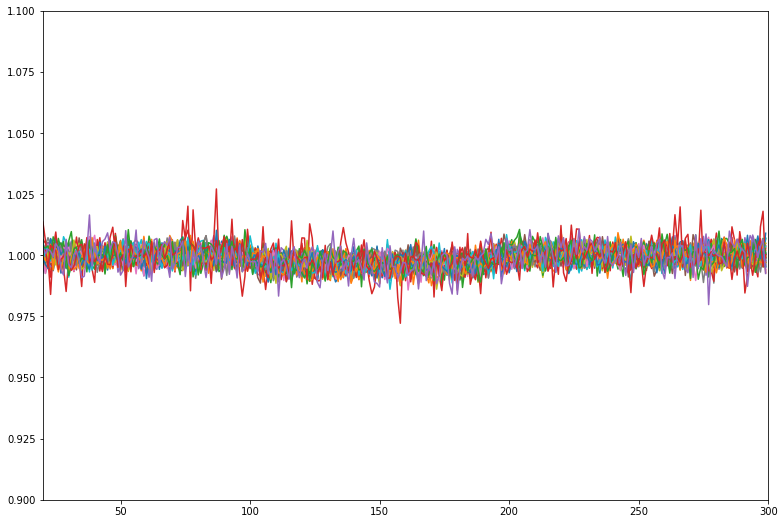

In [32]:

item = dataset[10]
plt.figure(figsize=(13,9))
plt.plot(item['lc'].T.detach().numpy())
# plt.plot(np.mean(item['lc'].T.detach().numpy(), axis=1))
plt.xlim((20, 300))
plt.ylim((0.9, 1.1))
plt.show()

### let's plot a random spectral light curve, just for fun

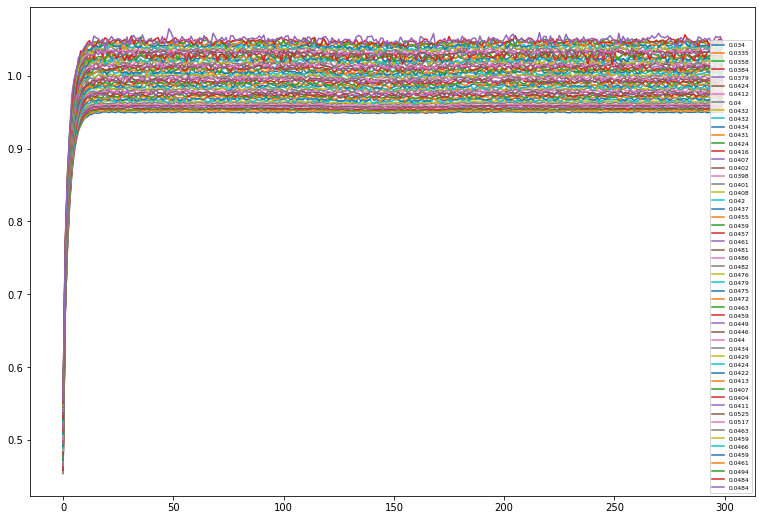

In [15]:

dataset = ArielMLDataset(lc_train_path, params_train_path, shuffle=True)
print(len(dataset))

idx = np.random.randint(len(dataset))
item = dataset[idx]
offsets = np.linspace(-0.05, 0.05, item['lc'].shape[0])
f, ax = plt.subplots(figsize=(13,9))
plt.plot(item['lc'].T.detach().numpy() + offsets , label=None)
ax.legend([round(x, 4) for x in item['target'].detach().numpy()], fontsize=6, loc='lower right')

In [17]:
len(dataset)

125600

## Define simples preprocessing steps
- smoothing 
- clipping
- normalisation per wavelength
- removing ramp?

In [16]:
from utils import simple_transform

Let's include these steps in the datasets for convenience

In [18]:
random_seed = 0
train_size = 2048
val_size = 1024
test_size = 1024

# Training
dataset_train = ArielMLDataset(lc_train_path, params_train_path, shuffle=True, start_ind=0, 
                               max_size=train_size, transform=simple_transform, seed=random_seed)
# Validation
dataset_val = ArielMLDataset(lc_train_path, params_train_path, shuffle=True, start_ind=train_size, 
                             max_size=val_size, transform=simple_transform, seed=random_seed)

# Testing
dataset_test = ArielMLDataset(lc_train_path, params_train_path, start_ind=train_size+val_size, 
                              shuffle=True, max_size=test_size, transform=simple_transform, seed=random_seed)

# Evaluation : no output path available here, this will only be used for submission
dataset_eval = ArielMLDataset(lc_test_path, shuffle=False, transform=simple_transform)

Let's define the corresponding data loaders, still using Pytorch utils module

In [19]:
from torch.utils.data.dataloader import DataLoader

batch_size = 256 #int(train_size / 4)

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size)
loader_test = DataLoader(dataset_test, batch_size=batch_size)
loader_eval = DataLoader(dataset_eval, batch_size=1000, shuffle=False)

### Challenge's Metric

The scoring system used for evaluation is defined here: https://www.ariel-datachallenge.space/ML/documentation/scoring

Let's define it roughly here, with unity weights as we don't have the actual weights available. Note that this might likely lead to conservative (pessimistic) score estimation as the real metric gives smaller weights to the hardest samples (in terms of signal-to-noise), whereas here all the samples have equal weighting.

In [20]:
from utils import ChallengeMetric
    
challenge_metric = ChallengeMetric()

## Models

A constant prediction model for reference

In [21]:
naive_1 = lambda x: torch.ones(x.shape[:-1]) * 0.06  

The baseline model, a fully connected neural network with 2 hidden layers with ReLU activation functions.

In [22]:
from utils import Baseline
    
baseline = Baseline().double().to(device)
baseline

Baseline(
  (network): Sequential(
    (0): Linear(in_features=16500, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=55, bias=True)
  )
)

In [1]:
from models import MLP, Baseline, DilatedNet
model = DilatedNet()
model

DilatedNet(
  (cnn): Sequential(
    (0): UConv1d(
      (layers): Sequential(
        (0): Conv1d(55, 64, kernel_size=(7,), stride=(1,), padding=(6,), dilation=(2,))
        (1): PReLU(num_parameters=1)
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UConv1d(
      (layers): Sequential(
        (0): Conv1d(64, 128, kernel_size=(7,), stride=(1,), padding=(6,), dilation=(2,))
        (1): PReLU(num_parameters=1)
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): UConv1d(
      (layers): Sequential(
        (0): Conv1d(128, 256, kernel_size=(7,), stride=(1,), padding=(6,), dilation=(2,))
        (1): PReLU(num_parameters=1)
        (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (flatten): Flatten()
  (mlp): Sequential(
    (0): Linear(in_features=76800, out_features=200, bias=True)
    (1): BatchNo

### Training the baseline

In [23]:
from torch.optim import Adam
from torch.nn import MSELoss, L1Loss

opt = Adam(baseline.parameters(), lr=0.0005)
loss_function = MSELoss()  # Alternatives could be ChallengeMetric() or L1Loss()

train_losses = []
val_losses = []
val_scores = []
best_val_score = 0.        

In [29]:
from tqdm import tqdm
save_from = 3
epochs = 200

for epoch in tqdm(range(1, 1+epochs)):
    print(epoch)
    train_loss = 0
    val_loss = 0
    val_score = 0
    baseline.train()
    for k, item in enumerate(loader_train):
        item['lc'] = item['lc'].to(device)
        item['target'] = item['target'].to(device)
        pred = baseline(item['lc'])
        loss = loss_function(item['target'], pred)
        opt.zero_grad()
        loss.backward()
        opt.step()    
        train_loss += loss.detach().item()
    train_loss = train_loss / len(loader_train)
    
    baseline.eval()
    for k, item in enumerate(loader_val):
        item['lc'] = item['lc'].to(device)
        item['target'] = item['target'].to(device)
        pred = baseline(item['lc'])
        loss = loss_function(item['target'], pred)
        score = challenge_metric.score(item['target'], pred)
        val_loss += loss.detach().item()
        val_score += score.detach().item()
    val_loss /= len(loader_val)
    val_score /= len(loader_val)
    print('Training loss', round(train_loss, 6))
    print('Val loss', round(val_loss, 6))
    print('Val score', round(val_score, 2))
    train_losses += [train_loss]
    val_losses += [val_loss]
    val_scores += [val_score]
    
    if epoch >= save_from and val_score > best_val_score:
        best_val_score = val_score
        torch.save(baseline, 'outputs/model_state.pt')
    
# Val loss 0.000162
# Val score 8799.57

1
Training loss 0.005896
Val loss 0.00388
Val score 3224.45
2
Training loss 0.003028
Val loss 0.002399
Val score 4551.05
3
Training loss 0.001777
Val loss 0.001428
Val score 5898.99
4
Training loss 0.001286
Val loss 0.000925
Val score 6753.89
5
Training loss 0.000864
Val loss 0.000803
Val score 6935.13
6
Training loss 0.000655
Val loss 0.000718
Val score 7085.77
7
Training loss 0.000532
Val loss 0.0006
Val score 7358.42
8
Training loss 0.000476
Val loss 0.000492
Val score 7697.09
9
Training loss 0.000347
Val loss 0.000463
Val score 7764.23
10
Training loss 0.000295
Val loss 0.000393
Val score 7966.31
11
Training loss 0.00025
Val loss 0.000367
Val score 7998.03
12
Training loss 0.000218
Val loss 0.000326
Val score 8162.74
13
Training loss 0.000186
Val loss 0.000311
Val score 8242.12
14
Training loss 0.000162
Val loss 0.000284
Val score 8267.19
15
Training loss 0.000144
Val loss 0.00027
Val score 8347.06
16
Training loss 0.000126
Val loss 0.000251
Val score 8446.33
17
Training loss 0.000

KeyboardInterrupt: 

Let's look at the learning curve

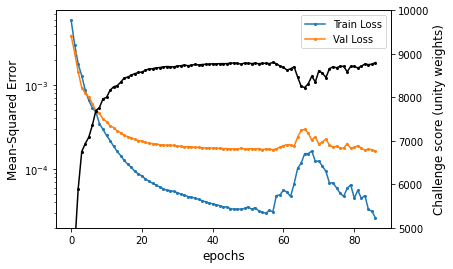

In [30]:
f, ax = plt.subplots()
plt.plot(train_losses, '-o', label='Train Loss', markersize=2)
plt.plot(val_losses, '-o', label='Val Loss', markersize=2)
plt.xlabel('epochs', fontsize=12)
plt.ylabel('Mean-Squared Error', fontsize=12)
plt.yscale('log')
plt.legend()

secay = ax.twinx()
secay.plot()
secay.plot(val_scores, '-o', label='Val Score', markersize=2, color='black')
secay.set_xlabel('epochs', fontsize=12)
secay.set_ylabel('Challenge score (unity weights)', fontsize=12)
secay.set_ylim(5000,10000)
pass

let's reload the model with the best validation loss

In [34]:
baseline = torch.load('outputs/model_state.pt')
baseline.eval()

Baseline(
  (network): Sequential(
    (0): Linear(in_features=16500, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=55, bias=True)
  )
)

### Compare models on test set

In [38]:
item = next(iter(loader_test))
item['lc'] = item['lc'].to(device)
preds = {'naive1': naive_1(item['lc']), 
         'normal_1000ppm': torch.normal(item['target'], 1e-3),
         'baseline': baseline(item['lc'])
        }

for name, pred in preds.items():
    print(name, f"\t{challenge_metric.score(item['target'], pred.cpu()).item():.2f}")

naive1 	6739.04
normal_1000ppm 	9917.42
baseline 	8980.84


### Produce evaluation vectors
(takes a several mins to run)

In [44]:
%%time
from tqdm import tqdm
preds = []

for k, item in tqdm(enumerate(loader_eval)):
    item['lc'] = item['lc'].to(device)
    preds += [baseline(item['lc'])]

eval_pred = torch.cat(preds).detach().numpy()

1it [03:24, 204.88s/it]


KeyboardInterrupt: 

In [50]:
eval_pred = preds[0]

Let's quickly plot the mean results per wavelength

Text(0, 0.5, 'mean prediction per wavelength')

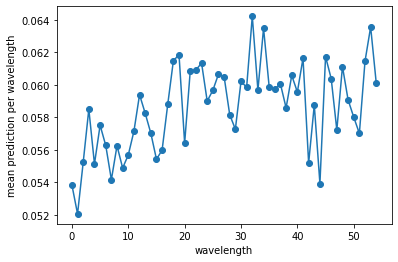

In [53]:
plt.plot(eval_pred.detach().cpu().mean(0), '-o')
plt.xlabel('wavelength')
plt.ylabel('mean prediction per wavelength')

And finally save the results as a txt file:

In [ ]:
import datetime 

save_path = f'outputs/baseline_evaluation_{datetime.datetime.today().date()}.txt'
if save_path and (53900, 55) == eval_pred.shape:
    np.savetxt(save_path, eval_pred, fmt='%.10f', delimiter='\t')